In [1]:
import numpy as np
import matplotlib.pyplot as plt
from get_images import get_images

# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F

# Get Images

In [2]:
MNIST_PATH = './Dataset/'

In [3]:
x_train_num, y_train_num, x_test_num, y_test_num = get_images(MNIST_PATH)

In [4]:
#Training set
x_train = x_train_num[:50000].reshape(50000,-1).astype(np.float32)/255 ##Convert the traint set into a (50000, 28x28) matrix normalized
y_train = y_train_num[:50000].reshape(50000,1)

##Validation set
x_val = x_train_num[50000:].reshape(10000,-1).astype(np.float32)/255
y_val = y_train_num[50000:].reshape(10000,1)

##Test set
x_test = x_test_num.copy().reshape(10000,-1).astype(np.float32)/255
y_test = y_test_num.copy().reshape(10000,1)

## Normalize images

In [5]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [6]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [7]:
x_train.mean(), x_train.std()

(8.5686665e-08, 0.9999983)

## Show Images

In [8]:
x_test.shape

(10000, 784)

In [9]:
y_train.shape

(50000, 1)

In [10]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 5


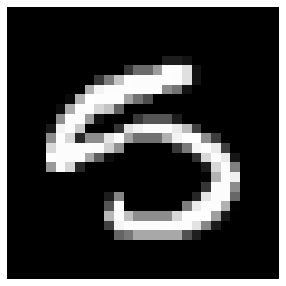

In [13]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

## Create Mini Batches

In [14]:
def create_minibatches(x, y, mb_size, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data, dtype=float)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

# Pytorch 

In [16]:
x_train_tensor = torch.Tensor(x_train.copy())
y_train_tensor = torch.Tensor(y_train.copy())

x_val_tensor = torch.Tensor(x_val.copy())
y_val_tensor = torch.Tensor(y_val.copy())

x_test_tensor = torch.Tensor(x_test.copy())
y_test_tensor = torch.Tensor(y_test.copy())

## Use GPU when available

In [17]:
torch.cuda.is_available()

True

In [18]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estamos usando: {device}')

Estamos usando: cuda


# Accuracy

In [19]:
def accuracy(model: nn.Sequential, x: torch.tensor, y: torch.tensor, mb_size: int):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

            return float(num_correct)/num_total  

# Train

In [20]:
def train(model: nn.Sequential, optimizer: torch.optim.SGD, scheduler, mb_size: int, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
      for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # cost function
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
      scheduler.step()
            
      print(f'Epoch: {epoch}, lr:{scheduler.get_last_lr()}, costo: {cost.item()}, accuracy: {accuracy(model, x_val_tensor, y_val_tensor, mb_size)}')

In [22]:
def train(model, optimiser, mb_size):
    model = model.to(device=device)
    epoch_acc = 0.0
    #plot lists
    acc_list = [0.0]
    cost_list = [0.0]
    #training while
    while epoch_acc < 0.95:
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # cost function
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
        epoch_acc = accuracy(model, x_val_tensor, y_val_tensor, mb_size)
        epoch_cost = cost.item()
        #append
        acc_list.append(epoch_acc)
        #append cost
        cost_list.append(epoch_cost)
        print(f'Epoch: {len(acc_list)}, costo: {epoch_cost}, accuracy: {epoch_acc}')
    return acc_list, cost_list
      

# Def Model

In [23]:
#Parametros del modelo
hidden1 = 1000 
hidden = 1000
lr = 1e-2
epochs = 100
mb_size = 4096

## SGD

In [24]:
modelSGD = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))
optimiserSGD = torch.optim.SGD(modelSGD.parameters(), lr=lr)

SGD_acc_list, SGD_cost_list = train(modelSGD, optimiserSGD, mb_size)

Epoch: 2, costo: 2.2315869331359863, accuracy: 0.373291015625
Epoch: 3, costo: 2.1472856998443604, accuracy: 0.609130859375
Epoch: 4, costo: 2.0639820098876953, accuracy: 0.705078125
Epoch: 5, costo: 1.9610345363616943, accuracy: 0.724853515625
Epoch: 6, costo: 1.8614274263381958, accuracy: 0.74072265625
Epoch: 7, costo: 1.7436028718948364, accuracy: 0.748046875
Epoch: 8, costo: 1.6242737770080566, accuracy: 0.769287109375
Epoch: 9, costo: 1.477858066558838, accuracy: 0.77734375
Epoch: 10, costo: 1.3460428714752197, accuracy: 0.79296875
Epoch: 11, costo: 1.2056536674499512, accuracy: 0.809814453125
Epoch: 12, costo: 1.1218503713607788, accuracy: 0.807373046875
Epoch: 13, costo: 1.009346604347229, accuracy: 0.8330078125
Epoch: 14, costo: 0.9368172883987427, accuracy: 0.83984375
Epoch: 15, costo: 0.8673577308654785, accuracy: 0.847412109375
Epoch: 16, costo: 0.8383375406265259, accuracy: 0.84765625
Epoch: 17, costo: 0.755142331123352, accuracy: 0.85546875
Epoch: 18, costo: 0.703348934650

In [25]:
SGD_acc = accuracy(modelSGD, x_test_tensor,  y_test_tensor, mb_size)

## SGD con Momentum

In [26]:
modelSGDM = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))
optimiserSGDM = torch.optim.SGD(modelSGDM.parameters(), lr=lr, momentum=0.9)

SGDM_acc_list, SGDM_cost_list = train(modelSGDM, optimiserSGDM, mb_size)

Epoch: 2, costo: 1.9953302145004272, accuracy: 0.7216796875
Epoch: 3, costo: 1.1957496404647827, accuracy: 0.79541015625
Epoch: 4, costo: 0.6280062198638916, accuracy: 0.852783203125
Epoch: 5, costo: 0.4599311053752899, accuracy: 0.884521484375
Epoch: 6, costo: 0.3977142572402954, accuracy: 0.90185546875
Epoch: 7, costo: 0.3932632803916931, accuracy: 0.908447265625
Epoch: 8, costo: 0.3099234104156494, accuracy: 0.908447265625
Epoch: 9, costo: 0.28180885314941406, accuracy: 0.91552734375
Epoch: 10, costo: 0.27127695083618164, accuracy: 0.916748046875
Epoch: 11, costo: 0.30810078978538513, accuracy: 0.9150390625
Epoch: 12, costo: 0.2856054902076721, accuracy: 0.923583984375
Epoch: 13, costo: 0.3363826274871826, accuracy: 0.927001953125
Epoch: 14, costo: 0.26281821727752686, accuracy: 0.9287109375
Epoch: 15, costo: 0.2778403162956238, accuracy: 0.927001953125
Epoch: 16, costo: 0.2608916759490967, accuracy: 0.931884765625
Epoch: 17, costo: 0.2270253598690033, accuracy: 0.934326171875
Epoch

In [27]:
SGDM_acc = accuracy(modelSGDM, x_test_tensor,  y_test_tensor, mb_size)

## RMSProp

In [28]:
modelRMSP = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))
optimiserRMSP = torch.optim.RMSprop(modelRMSP.parameters(), lr=lr, alpha=0.9)

RMSP_acc_list, RMSP_cost_list = train(modelRMSP, optimiserRMSP, mb_size)

Epoch: 2, costo: 0.8925046324729919, accuracy: 0.789794921875
Epoch: 3, costo: 0.6289525032043457, accuracy: 0.892578125
Epoch: 4, costo: 0.454149454832077, accuracy: 0.9013671875
Epoch: 5, costo: 0.47904181480407715, accuracy: 0.81494140625
Epoch: 6, costo: 0.30368903279304504, accuracy: 0.9052734375
Epoch: 7, costo: 0.23051077127456665, accuracy: 0.944091796875
Epoch: 8, costo: 0.2284485101699829, accuracy: 0.945556640625
Epoch: 9, costo: 0.1767520308494568, accuracy: 0.912353515625
Epoch: 10, costo: 0.7415668368339539, accuracy: 0.94140625
Epoch: 11, costo: 0.16778111457824707, accuracy: 0.91455078125
Epoch: 12, costo: 0.6962103247642517, accuracy: 0.783203125
Epoch: 13, costo: 0.14944790303707123, accuracy: 0.95654296875


In [29]:
RMSP_acc = accuracy(modelRMSP, x_test_tensor,  y_test_tensor, mb_size)

## Adam

In [30]:
modelAdam = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))
optimiserAdam = torch.optim.Adam(modelAdam.parameters(), lr=lr, betas=(0.9, 0.999))

Adam_acc_list, Adam_cost_list = train(modelAdam, optimiserAdam, mb_size)

Epoch: 2, costo: 0.6039091348648071, accuracy: 0.85205078125
Epoch: 3, costo: 0.2820046842098236, accuracy: 0.935546875
Epoch: 4, costo: 0.17356421053409576, accuracy: 0.94189453125
Epoch: 5, costo: 0.13712270557880402, accuracy: 0.96533203125


In [31]:
Adam_acc = accuracy(modelAdam, x_test_tensor,  y_test_tensor, mb_size)

In [32]:
SGD_acc, SGDM_acc, RMSP_acc, Adam_acc

(0.9462890625, 0.943115234375, 0.95556640625, 0.958984375)

# Plot Section

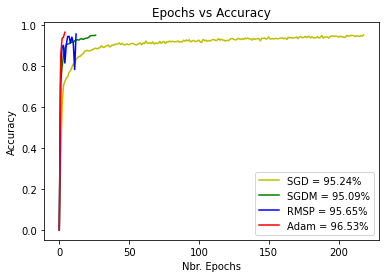

In [33]:
x_axis = range(len(SGDM_acc_list))
y_axis = np.linspace(0,5,10)

#Modificar grafica
#Tratar de buscar algunos papers para ver como grafican

plt.plot(range(len(SGD_acc_list)), SGD_acc_list, 'y', label='SGD = {acc}%'.format(acc = round(SGD_acc_list[-1] * 100 , 2)))
plt.plot(range(len(SGDM_acc_list)), SGDM_acc_list, 'g', label='SGDM = {acc}%'.format(acc = round(SGDM_acc_list[-1] * 100, 2)))
plt.plot(range(len(RMSP_acc_list)), RMSP_acc_list, 'b', label='RMSP = {acc}%'.format(acc = round(RMSP_acc_list[-1] * 100, 2)))
plt.plot(range(len(Adam_acc_list)), Adam_acc_list, 'r', label='Adam = {acc}%'.format(acc = round(Adam_acc_list[-1] * 100, 2)))

plt.title('Epochs vs Accuracy')
plt.xlabel('Nbr. Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
print(torch.__version__)

1.13.1+cu117
